In [ ]:
!pip install tensorflow==2.5.0
!pip install numpy==1.20.3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import shutil
shutil.copy2("/content/drive/MyDrive/utilities.py", "/content/utilities.py")
shutil.copy2("/content/drive/MyDrive/ConvNet.py", "/content/ConvNet.py")
shutil.copy2("/content/drive/MyDrive/config.py", "/content/config.py")

'/content/config.py'

In [2]:
import ConvNet
import config
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import os
import numpy as np
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Audio, clear_output, display
from glob import glob
import random
from utilities import acuracia0, acuracia1, acuracia2
import utilities

In [3]:
model = ConvNet.ConvNet

In [ ]:
model.summary()

# k=1

In [6]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/treino1.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/teste1.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/validation1.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [7]:
TRAIN_DATASET = os.path.join("/content", "treino1")
VAL_DATASET = os.path.join("/content", "validation1")
TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [12]:
list_images_train = list(images_train.as_numpy_iterator())

In [13]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [14]:
list_images_test = list(images_test.as_numpy_iterator())

In [15]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [16]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7060, 40, 256, 1)
(883, 40, 256, 1)
(7060,)
(883,)
(883,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [17]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [18]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [19]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [20]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 40s - loss: 5.2520 - accuracy: 0.0182

111/111 [==============================] - 8s 72ms/step
Train - Acurácia 0:  0.18626062322946177
Train - Acurácia 2:  0.44886685552407934
14/14 [==============================] - 1s 72ms/step
Validation - Acurácia 0:  0.16987542468856173
validation - Acurácia 2:  0.46319365798414497
111/111 [==============================] - 76s 548ms/step - loss: 3.9816 - accuracy: 0.1976 - val_loss: 4.8088 - val_accuracy: 0.1699
Epoch 2/50
111/111 [==============================] - 8s 74ms/step
Train - Acurácia 0:  0.2905099150141643
Train - Acurácia 2:  0.624929178470255
14/14 [==============================] - 1s 74ms/step
Validation - Acurácia 0:  0.26160815402038506
validation - Acurácia 2:  0.6160815402038505
111/111 [==============================] - 57s 513ms/step - loss: 2.9556 - accuracy: 0.3098 - val_loss: 3.3865 - val_accuracy: 0.2616
Epoch 3/50
111/111 [==============================] - 8s 76ms/step
Train - Acurácia 0:  0.28456090651558075
Train - Acurácia 2:  0.6297450424929179
14/14 [==

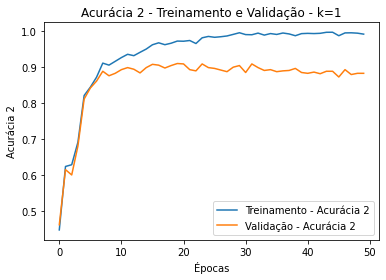

In [21]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'1')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k1'+'.pdf', format='pdf')
plt.show()

In [22]:
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k1',acc)
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/val_acc2_'+'k1',val_acc)

In [23]:
model.save('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k1')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k1')

### Training Results

In [24]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 77ms/step
(7060, 140)
(7060,)
(7060,)


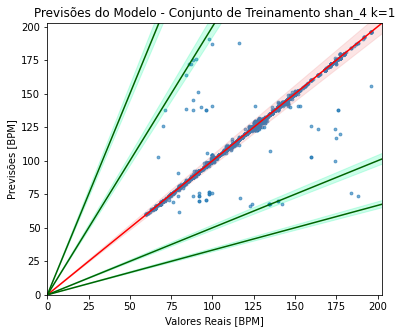

In [25]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_4 k=1', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_train_'+'k1'+'.pdf')

In [26]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_4_k=1'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_4_k=1    0.921813     0.99051     0.992068


### Validation Results

In [27]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 76ms/step
(883, 140)
(883, 140)
(883,)
(883,)


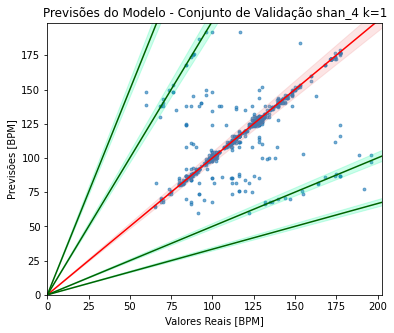

In [28]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_4 k=1', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_validation_'+'k1'+'.pdf')

In [29]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_4_k=1'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=1    0.921813    0.990510     0.992068
1  validation_shan_4_k=1    0.491506    0.844847     0.883352


### Test Results

In [30]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 76ms/step
(883, 140)
(883, 140)
(883,)
(883,)


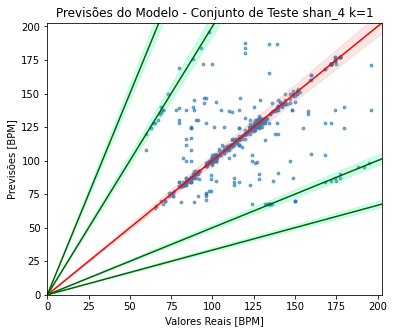

In [31]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste shan_4 k=1', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_test_'+'k1'+'.pdf')

In [32]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_shan_4_k=1'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=1    0.921813    0.990510     0.992068
1  validation_shan_4_k=1    0.491506    0.844847     0.883352
2        test_shan_4_k=1    0.502831    0.842582     0.878822


In [33]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_4_kfold/Resultados_shan_4_k1.xlsx", index=False)  

# k=2

In [5]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/treino2.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/teste2.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/validation2.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "treino2")
VAL_DATASET = os.path.join("/content", "validation2")
TEST_DATASET = os.path.join("/content", "teste2")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [9]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [10]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [13]:
list_images_test = list(images_test.as_numpy_iterator())

In [14]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [15]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [16]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [17]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [18]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [19]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 41s - loss: 5.2096 - accuracy: 0.0234

111/111 [==============================] - 8s 73ms/step
Train - Acurácia 0:  0.14301897479467574
Train - Acurácia 2:  0.4056924384027188
14/14 [==============================] - 1s 73ms/step
Validation - Acurácia 0:  0.15192743764172337
validation - Acurácia 2:  0.42630385487528344
111/111 [==============================] - 72s 554ms/step - loss: 4.2746 - accuracy: 0.1512 - val_loss: 6.5780 - val_accuracy: 0.1519
Epoch 2/50
111/111 [==============================] - 8s 75ms/step
Train - Acurácia 0:  0.30756159728122345
Train - Acurácia 2:  0.6241857830642877
14/14 [==============================] - 1s 75ms/step
Validation - Acurácia 0:  0.29138321995464855
validation - Acurácia 2:  0.6111111111111112
111/111 [==============================] - 58s 522ms/step - loss: 3.1111 - accuracy: 0.2884 - val_loss: 3.4846 - val_accuracy: 0.2914
Epoch 3/50
111/111 [==============================] - 8s 77ms/step
Train - Acurácia 0:  0.3399886717643727
Train - Acurácia 2:  0.7180685358255452
14/14 [==

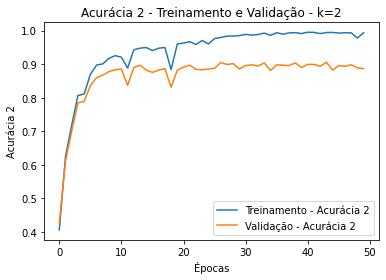

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'2')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k2'+'.pdf', format='pdf')
plt.show()

In [21]:
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k2',acc)
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/val_acc2_'+'k2',val_acc)

In [22]:
model.save('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k2')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k2')

### Training Results

In [23]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 8s 75ms/step
(7062, 140)
(7062,)
(7062,)


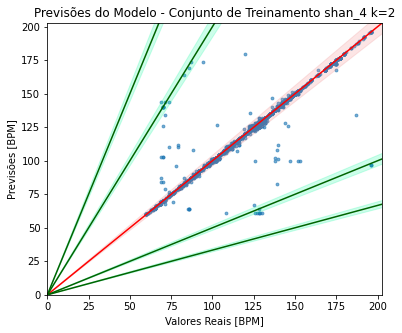

In [24]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_4 k=2', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_train_'+'k2'+'.pdf')

In [25]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_4_k=2'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_4_k=2    0.918578    0.990513     0.993486


### Validation Results

In [26]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 74ms/step
(882, 140)
(882, 140)
(882,)
(882,)


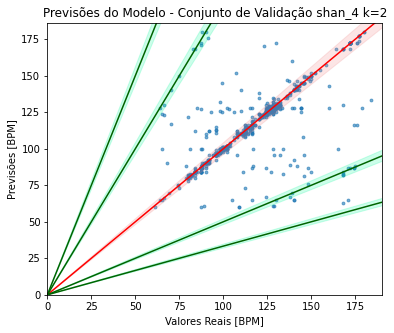

In [27]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_4 k=2', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_validation_'+'k2'+'.pdf')

In [28]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_4_k=2'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=2    0.918578    0.990513     0.993486
1  validation_shan_4_k=2    0.488662    0.857143     0.886621


### Test Results

In [29]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 74ms/step
(882, 140)
(882, 140)
(882,)
(882,)


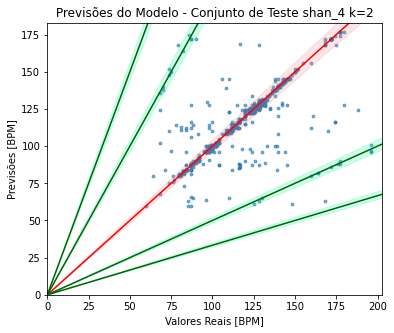

In [30]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste shan_4 k=2', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_test_'+'k2'+'.pdf')

In [31]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_shan_4_k=2'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=2    0.918578    0.990513     0.993486
1  validation_shan_4_k=2    0.488662    0.857143     0.886621
2        test_shan_4_k=2    0.513605    0.859410     0.884354


In [32]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_4_kfold/Resultados_shan_4_k2.xlsx", index=False)  

# k=3

In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/treino3.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/teste3.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/validation3.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [5]:
TRAIN_DATASET = os.path.join("/content", "treino3")
VAL_DATASET = os.path.join("/content", "validation3")
TEST_DATASET = os.path.join("/content", "teste3")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [6]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [8]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [9]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [10]:
list_images_train = list(images_train.as_numpy_iterator())

In [11]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [12]:
list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 41s - loss: 5.2000 - accuracy: 0.0156

111/111 [==============================] - 8s 74ms/step
Train - Acurácia 0:  0.20971396205041065
Train - Acurácia 2:  0.4647408666100255
14/14 [==============================] - 1s 73ms/step
Validation - Acurácia 0:  0.20068027210884354
validation - Acurácia 2:  0.47392290249433106
111/111 [==============================] - 72s 556ms/step - loss: 4.1793 - accuracy: 0.1844 - val_loss: 5.4519 - val_accuracy: 0.2007
Epoch 2/50
111/111 [==============================] - 8s 75ms/step
Train - Acurácia 0:  0.2599830076465591
Train - Acurácia 2:  0.5696686491079015
14/14 [==============================] - 1s 75ms/step
Validation - Acurácia 0:  0.24603174603174602
validation - Acurácia 2:  0.5770975056689343
111/111 [==============================] - 58s 523ms/step - loss: 3.0053 - accuracy: 0.3214 - val_loss: 3.2125 - val_accuracy: 0.2460
Epoch 3/50
111/111 [==============================] - 8s 76ms/step
Train - Acurácia 0:  0.34225431888983293
Train - Acurácia 2:  0.6930048145001416
14/14 [==

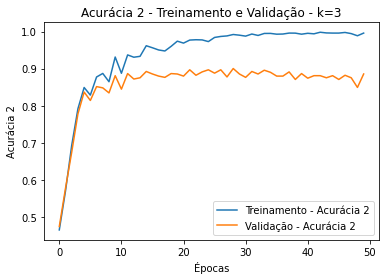

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'3')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k3'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k3',acc)
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/val_acc2_'+'k3',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k3')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k3')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 77ms/step
(7062, 140)
(7062,)
(7062,)


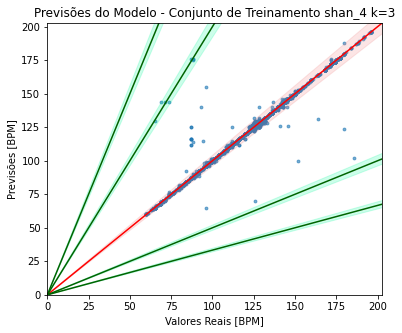

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_4 k=3', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_train_'+'k3'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_4_k=3'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_4_k=3    0.934579    0.995044     0.995894


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 76ms/step
(882, 140)
(882, 140)
(882,)
(882,)


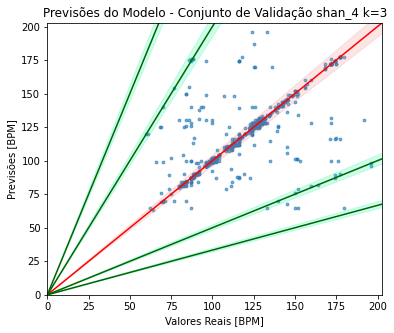

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_4 k=3', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_validation_'+'k3'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_4_k=3'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=3    0.934579    0.995044     0.995894
1  validation_shan_4_k=3    0.521542    0.860544     0.885488


### Test Results

In [28]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 76ms/step
(882, 140)
(882, 140)
(882,)
(882,)


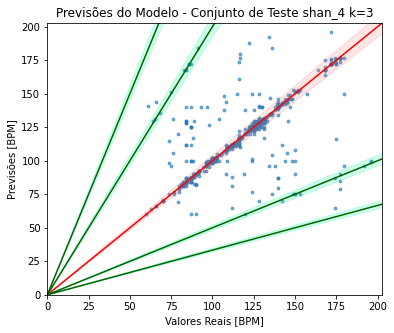

In [29]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste shan_4 k=3', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_test_'+'k3'+'.pdf')

In [30]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_shan_4_k=3'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=3    0.934579    0.995044     0.995894
1  validation_shan_4_k=3    0.521542    0.860544     0.885488
2        test_shan_4_k=3    0.537415    0.862812     0.890023


In [31]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_4_kfold/Resultados_shan_4_k3.xlsx", index=False)  

# k=4

In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/treino4.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/teste4.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/validation4.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [5]:
TRAIN_DATASET = os.path.join("/content", "treino4")
VAL_DATASET = os.path.join("/content", "validation4")
TEST_DATASET = os.path.join("/content", "teste4")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [6]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [8]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [9]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [10]:
list_images_train = list(images_train.as_numpy_iterator())

In [11]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [12]:
list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 40s - loss: 5.2450 - accuracy: 0.0260

111/111 [==============================] - 8s 73ms/step
Train - Acurácia 0:  0.1508071367884452
Train - Acurácia 2:  0.42948173322005095
14/14 [==============================] - 1s 73ms/step
Validation - Acurácia 0:  0.1621315192743764
validation - Acurácia 2:  0.42857142857142855
111/111 [==============================] - 71s 551ms/step - loss: 3.9563 - accuracy: 0.1910 - val_loss: 4.8431 - val_accuracy: 0.1621
Epoch 2/50
111/111 [==============================] - 8s 75ms/step
Train - Acurácia 0:  0.2107051826677995
Train - Acurácia 2:  0.48867176437269894
14/14 [==============================] - 1s 74ms/step
Validation - Acurácia 0:  0.23469387755102042
validation - Acurácia 2:  0.4977324263038549
111/111 [==============================] - 58s 520ms/step - loss: 2.8756 - accuracy: 0.3233 - val_loss: 4.5682 - val_accuracy: 0.2347
Epoch 3/50
111/111 [==============================] - 8s 76ms/step
Train - Acurácia 0:  0.34593599546870574
Train - Acurácia 2:  0.6625601812517701
14/14 [==

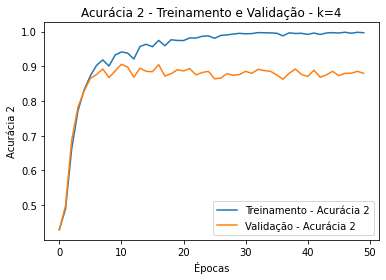

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'4')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k4'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k4',acc)
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/val_acc2_'+'k4',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k4')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k4')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 8s 77ms/step
(7062, 140)
(7062,)
(7062,)


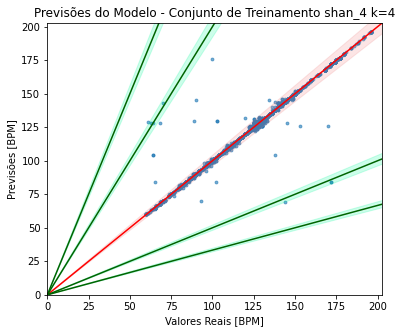

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_4 k=4', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_train_'+'k4'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_4_k=4'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_4_k=4    0.936562    0.996035     0.996743


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 76ms/step
(882, 140)
(882, 140)
(882,)
(882,)


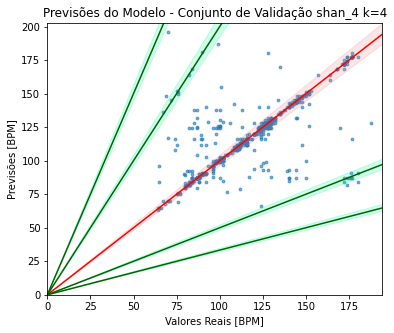

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_4 k=4', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_validation_'+'k4'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_4_k=4'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=4    0.936562    0.996035     0.996743
1  validation_shan_4_k=4    0.543084    0.858277     0.879819


### Test Results

In [28]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 76ms/step
(882, 140)
(882, 140)
(882,)
(882,)


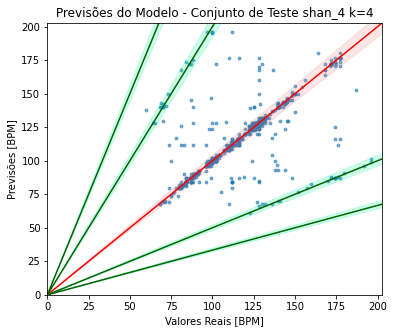

In [29]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste shan_4 k=4', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_test_'+'k4'+'.pdf')

In [30]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_shan_4_k=4'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=4    0.936562    0.996035     0.996743
1  validation_shan_4_k=4    0.543084    0.858277     0.879819
2        test_shan_4_k=4    0.537415    0.858277     0.899093


In [31]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_4_kfold/Resultados_shan_4_k4.xlsx", index=False)  

# k=5

In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/treino5.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/teste5.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_shan_4_review_split/validation5.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [5]:
TRAIN_DATASET = os.path.join("/content", "treino5")
VAL_DATASET = os.path.join("/content", "validation5")
TEST_DATASET = os.path.join("/content", "teste5")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [6]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [8]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [9]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [10]:
list_images_train = list(images_train.as_numpy_iterator())

In [11]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [12]:
list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 41s - loss: 5.0911 - accuracy: 0.0443

111/111 [==============================] - 8s 73ms/step
Train - Acurácia 0:  0.20475785896346643
Train - Acurácia 2:  0.49263664684225433
14/14 [==============================] - 1s 73ms/step
Validation - Acurácia 0:  0.20634920634920634
validation - Acurácia 2:  0.4909297052154195
111/111 [==============================] - 72s 553ms/step - loss: 3.7963 - accuracy: 0.2107 - val_loss: 5.3915 - val_accuracy: 0.2063
Epoch 2/50
111/111 [==============================] - 8s 75ms/step
Train - Acurácia 0:  0.3007646559048428
Train - Acurácia 2:  0.6911639762107051
14/14 [==============================] - 1s 75ms/step
Validation - Acurácia 0:  0.26643990929705214
validation - Acurácia 2:  0.6791383219954649
111/111 [==============================] - 58s 520ms/step - loss: 2.7867 - accuracy: 0.3423 - val_loss: 2.8996 - val_accuracy: 0.2664
Epoch 3/50
111/111 [==============================] - 8s 76ms/step
Train - Acurácia 0:  0.4086661002548853
Train - Acurácia 2:  0.7854715378079864
14/14 [===

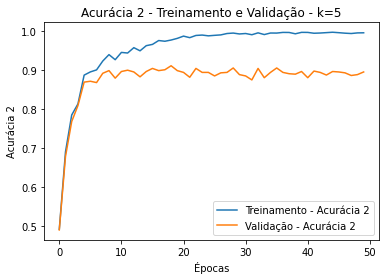

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'5')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k5'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/acc2_'+'k5',acc)
np.save('/content/drive/MyDrive/Resultados/shan_4_kfold/val_acc2_'+'k5',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_4_kfold/shan_4_kfold_'+'k5')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 77ms/step
(7062, 140)
(7062,)
(7062,)


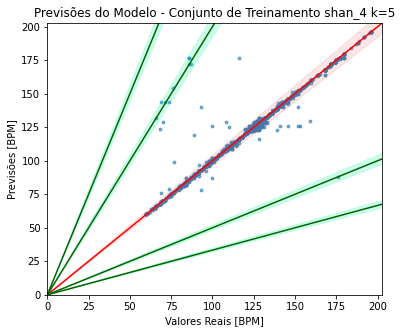

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_4 k=5', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_train_'+'k5'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_4_k=5'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_4_k=5     0.93288    0.995185     0.996035


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 76ms/step
(882, 140)
(882, 140)
(882,)
(882,)


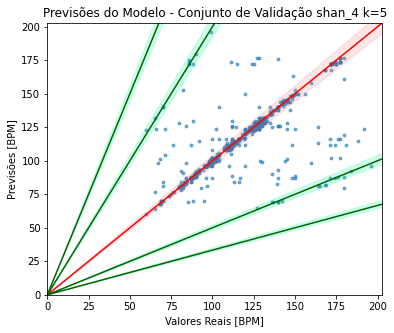

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_4 k=5', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_validation_'+'k5'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_4_k=5'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=5     0.93288    0.995185     0.996035
1  validation_shan_4_k=5     0.50000    0.867347     0.895692


### Test Results

In [28]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 77ms/step
(882, 140)
(882, 140)
(882,)
(882,)


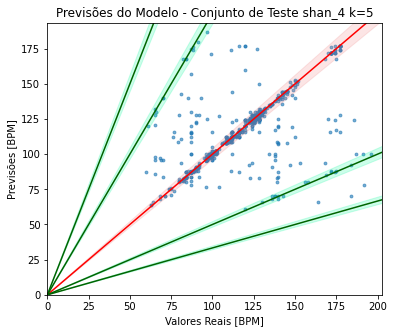

In [29]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste shan_4 k=5', '/content/drive/MyDrive/Resultados/shan_4_kfold/prev_test_'+'k5'+'.pdf')

In [30]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_shan_4_k=5'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_4_k=5    0.932880    0.995185     0.996035
1  validation_shan_4_k=5    0.500000    0.867347     0.895692
2        test_shan_4_k=5    0.515873    0.848073     0.884354


In [31]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_4_kfold/Resultados_shan_4_k5.xlsx", index=False)  